In [1]:
import os
import torch
import torchvision
import zipfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torch.utils.data import TensorDataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torch.optim as opt
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
with zipfile.ZipFile("/content/drive/MyDrive/Segmentation/rp_im.zip", "r") as z_fp:
    z_fp.extractall("./Train/")

In [4]:
with zipfile.ZipFile("/content/drive/MyDrive/Segmentation/rp_msk.zip", "r") as z_fp:
    z_fp.extractall("./Mask/")

In [5]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download  andrewmvd/mosmed-covid19-ct-scans

100% 1.71G/1.71G [00:23<00:00, 51.2MB/s]
100% 1.71G/1.71G [00:23<00:00, 79.6MB/s]


In [6]:
! unzip mosmed-covid19-ct-scans.zip

Archive:  mosmed-covid19-ct-scans.zip
  inflating: CT-2/study_0939.nii     
  inflating: CT-2/study_0940.nii     
  inflating: CT-2/study_0941.nii     
  inflating: CT-2/study_0942.nii     
  inflating: CT-2/study_0943.nii     
  inflating: CT-2/study_0944.nii     
  inflating: CT-2/study_0945.nii     
  inflating: CT-2/study_0946.nii     
  inflating: CT-2/study_0947.nii     
  inflating: CT-2/study_0948.nii     
  inflating: CT-2/study_0949.nii     
  inflating: CT-2/study_0950.nii     
  inflating: CT-2/study_0951.nii     
  inflating: CT-2/study_0952.nii     
  inflating: CT-2/study_0953.nii     
  inflating: CT-2/study_0954.nii     
  inflating: CT-2/study_0955.nii     
  inflating: CT-2/study_0956.nii     
  inflating: CT-2/study_0957.nii     
  inflating: CT-2/study_0958.nii     
  inflating: CT-2/study_0959.nii     
  inflating: CT-2/study_0960.nii     
  inflating: CT-2/study_0961.nii     
  inflating: CT-2/study_0962.nii     
  inflating: CT-2/study_0963.nii     
  inflating:

In [7]:
import nibabel as nib

from scipy import ndimage


def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

In [8]:
paths_images = [
    os.path.join(os.getcwd(), "/content/Train/rp_im", x)
    for x in os.listdir("/content/Train/rp_im")
]


paths_masks = [
    os.path.join(os.getcwd(), "/content/Mask/rp_msk", x)
    for x in os.listdir("/content/Mask/rp_msk")      
]

In [9]:
paths_images.append("/content/drive/MyDrive/Segmentation/tr_im.nii.gz")
paths_masks.append("/content/drive/MyDrive/Segmentation/tr_mask.nii.gz")

In [10]:
print("CT scans with normal lung tissue: " + str(len(paths_images)))
print("CT scans with normal lung tissue: " + str(len(paths_masks)))

CT scans with normal lung tissue: 10
CT scans with normal lung tissue: 10


In [16]:
paths_images2 = [
    os.path.join(os.getcwd(), "/content/CT-2", x)
    for x in os.listdir("/content/CT-2")
]

paths_images3 = [
    os.path.join(os.getcwd(), "/content/CT-3", x)
    for x in os.listdir("/content/CT-3")          
]

paths_images4 = [
    os.path.join(os.getcwd(), "/content/CT-4", x)
    for x in os.listdir("/content/CT-4")          
]

CT scans with normal lung tissue: 2


In [21]:
paths_images = paths_images+paths_images2+paths_images3+paths_images4
print("CT scans with normal lung tissue: " + str(len(paths)))

CT scans with normal lung tissue: 182


In [22]:
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
scans_images = np.array([process_scan(path) for path in paths_images])


In [23]:
x_train=torch.as_tensor(scans_images,dtype=torch.float32)
print("x_train : ",x_train.shape)

x_train :  torch.Size([182, 128, 128, 64])


In [24]:
import random

from scipy import ndimage



def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume


    augmented_volume = torch.tensor(scipy_rotate(volume), dtype=torch.float32)
    return augmented_volume


def train_preprocessing(volume):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    print(volume.shape)
    volume = torch.unsqueeze(volume,0)
    print("after")
    print(volume.shape)
    return volume


def validation_preprocessing(volume):
    """Process validation data by only adding a channel."""
    volume = torch.unsqueeze(volume,0)
    return volume

In [25]:
#Define dataset
train_dataset=TensorDataset(x_train)


In [26]:
# Check Dimensions
print("train_dataset : ",len(train_dataset))


train_dataset :  182


In [27]:
train_dataset=[train_preprocessing(*x) for x in train_dataset]

torch.Size([128, 128, 64])
after
torch.Size([1, 128, 128, 64])
torch.Size([128, 128, 64])
after
torch.Size([1, 128, 128, 64])
torch.Size([128, 128, 64])
after
torch.Size([1, 128, 128, 64])
torch.Size([128, 128, 64])
after
torch.Size([1, 128, 128, 64])
torch.Size([128, 128, 64])
after
torch.Size([1, 128, 128, 64])
torch.Size([128, 128, 64])
after
torch.Size([1, 128, 128, 64])
torch.Size([128, 128, 64])
after
torch.Size([1, 128, 128, 64])
torch.Size([128, 128, 64])
after
torch.Size([1, 128, 128, 64])
torch.Size([128, 128, 64])
after
torch.Size([1, 128, 128, 64])
torch.Size([128, 128, 64])
after
torch.Size([1, 128, 128, 64])
torch.Size([128, 128, 64])
after
torch.Size([1, 128, 128, 64])
torch.Size([128, 128, 64])
after
torch.Size([1, 128, 128, 64])
torch.Size([128, 128, 64])
after
torch.Size([1, 128, 128, 64])
torch.Size([128, 128, 64])
after
torch.Size([1, 128, 128, 64])
torch.Size([128, 128, 64])
after
torch.Size([1, 128, 128, 64])
torch.Size([128, 128, 64])
after
torch.Size([1, 128, 12

In [28]:
batch_size=2
train_loader=DataLoader(train_dataset,batch_size,shuffle=True,prefetch_factor=2)


Dimension of the CT scan is: torch.Size([1, 128, 128, 64])


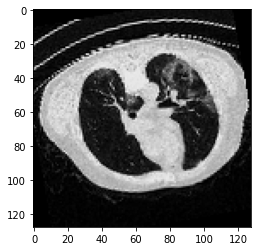

In [29]:
data = train_dataset[0]
image = data
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:,:, :, 30]), cmap="gray")

data :  torch.Size([1, 128, 128, 40])
data :  (128, 1, 128, 40)
data :  (40, 128, 1, 128)
data :  (4, 10, 128, 128)
data :  (4, 10, 128, 128)


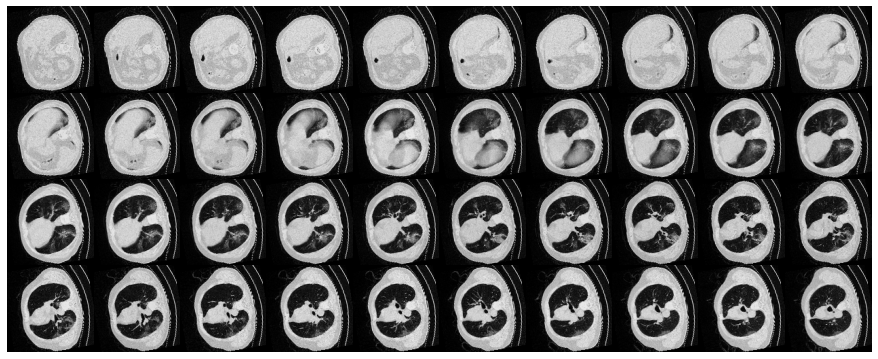

In [30]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    print("data : ",data.shape)
    data = np.rot90(np.array(data))
    print("data : ",data.shape)
    data = np.transpose(data)
    print("data : ",data.shape)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    print("data : ",data.shape)
    rows_data, columns_data = data.shape[0], data.shape[1]
    print("data : ",data.shape)
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()
plot_slices(4, 10, 128, 128, image[:, :, :, :40])

 99% 1.70G/1.71G [00:19<00:00, 73.3MB/s]
100% 1.71G/1.71G [00:19<00:00, 95.1MB/s]


In [ ]:
! unzip mosmed-covid19-ct-scans.zip

Archive:  mosmed-covid19-ct-scans.zip
  inflating: CT-2/study_0939.nii     
  inflating: CT-2/study_0940.nii     
  inflating: CT-2/study_0941.nii     
  inflating: CT-2/study_0942.nii     
  inflating: CT-2/study_0943.nii     
  inflating: CT-2/study_0944.nii     
  inflating: CT-2/study_0945.nii     
  inflating: CT-2/study_0946.nii     
  inflating: CT-2/study_0947.nii     
  inflating: CT-2/study_0948.nii     
  inflating: CT-2/study_0949.nii     
  inflating: CT-2/study_0950.nii     
  inflating: CT-2/study_0951.nii     
  inflating: CT-2/study_0952.nii     
  inflating: CT-2/study_0953.nii     
  inflating: CT-2/study_0954.nii     
  inflating: CT-2/study_0955.nii     
  inflating: CT-2/study_0956.nii     
  inflating: CT-2/study_0957.nii     
  inflating: CT-2/study_0958.nii     
  inflating: CT-2/study_0959.nii     
  inflating: CT-2/study_0960.nii     
  inflating: CT-2/study_0961.nii     
  inflating: CT-2/study_0962.nii     
  inflating: CT-2/study_0963.nii     
  inflating: